In [1]:
%matplotlib inline
from pathlib import Path
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from ml.models import Localizer, DigitClassifier

In [2]:
# Read image
DATA_DIR = Path('..', 'data')
img = cv2.imread(str(DATA_DIR / 'IMG_0096.jpg'))

In [3]:
# Load in localizer and digit classifier with weights
MODELS_DIR = Path('..', 'models')

localizer = Localizer()
digit_class = DigitClassifier()

checkpoint = torch.load(str(MODELS_DIR / 'localizer_best.pth.tar'), map_location='cpu')
localizer.load_state_dict(checkpoint['state_dict'])

checkpoint = torch.load(str(MODELS_DIR / 'digitclassifier_best.pth.tar'), map_location='cpu')
digit_class.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

0.9999995231628418


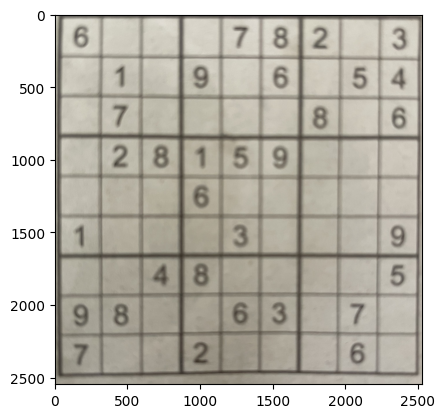

In [4]:
# Turn model into eval mode and infer sudoku location
localizer.eval()

def infer(img: cv2.Mat):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (224, 224))
    scale = [gray.shape[1] / resized.shape[1], gray.shape[0] / resized.shape[0]]

    input = torch.tensor(resized).reshape((1, 1, 224, 224)) / 255
    probs, locations = localizer(input)

    prob = probs.unsqueeze(0).item()
    location = (locations.reshape(-1, 2) * torch.tensor(scale)).reshape(-1).tolist()
    return prob, location

sudoku = img.copy()
prob, location = infer(sudoku)
x1, y1, x2, y2 = map(int, location)
sudoku = sudoku[y1:y2, x1:x2]

print(prob)
plt.imshow(cv2.cvtColor(sudoku, cv2.COLOR_BGR2RGB))


(<Axes: >, <matplotlib.image.AxesImage at 0x177873ad0>)

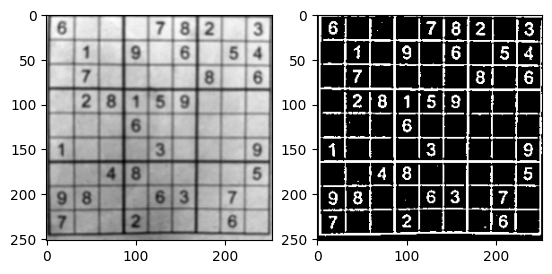

In [5]:
# Threshold the image
resized = cv2.resize(sudoku, (28 * 9, 28 * 9))
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3,3), 2)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 3)

morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, (3,3))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, (3,3))

# We could do even more here by slicing of the black areas beyond the sudoku
# points = cv2.findNonZero(thresh)
# x, y, w, h = cv2.boundingRect(points)
# thresh = thresh[y:y+h, x:x+w]

plt.subplot(1, 2, 1), plt.imshow(blurred, 'gray')
plt.subplot(1, 2, 2), plt.imshow(thresh, 'gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x1778c2c90>)

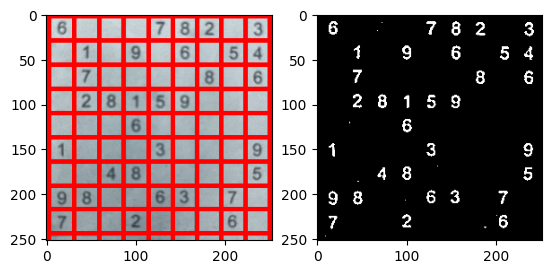

In [6]:
# Tangent on Hough line detection
# Wanted to see which method is better for removing lines

detected = resized.copy()
removed = thresh.copy()

non_zero = cv2.countNonZero(thresh)
lines = [
    *cv2.HoughLines(thresh, 1, np.pi / 180, 100, min_theta=0, max_theta=0), # Horizontal lines
    *cv2.HoughLines(thresh, 1, np.pi / 180, 100, min_theta=np.pi/2, max_theta=np.pi/2), # Vertical lines
]
for (line,) in lines:
    rho, theta = line
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(detected, pt1, pt2, (255, 0, 0), 3)
    cv2.line(removed, pt1, pt2, (0, 0, 0), 3)

plt.subplot(1, 2, 1), plt.imshow(detected)
plt.subplot(1, 2, 2), plt.imshow(removed, 'gray')


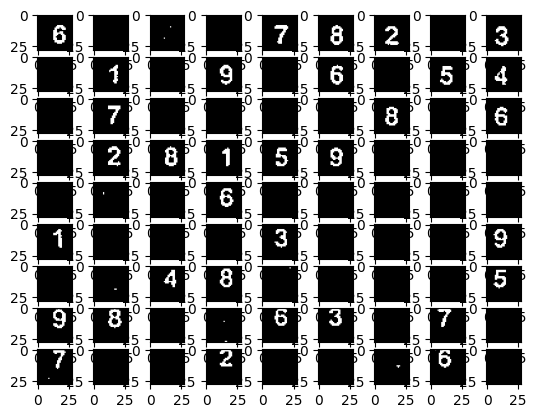

In [7]:
# Slice the image into 28x28 squares
DIGIT_SIZE = 28

final = cv2.resize(removed, (9*DIGIT_SIZE, 9*DIGIT_SIZE))
digits = torch.empty((9*9, 1, DIGIT_SIZE, DIGIT_SIZE))

for row in range(9):
    for col in range(9):
        digit = final[row*DIGIT_SIZE:(row+1)*DIGIT_SIZE, col*DIGIT_SIZE:(col+1)*DIGIT_SIZE]
        digits[9*row + col] = torch.tensor(digit).reshape(1, DIGIT_SIZE, DIGIT_SIZE) / 255
        plt.subplot(9, 9, row * 9 + col + 1)
        plt.imshow(digit, 'gray')
        

In [8]:
digit_class.eval()
out = digit_class(digits)
result = torch.nn.functional.softmax(out, dim=1).max(dim=1)
print(result.values.reshape(9,9))
print(result.indices.reshape(9,9))

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9377, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.9976, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000]],
       grad_fn=<ReshapeAliasBackward0>)
tensor([[6, 0, 0, 0, 7, 8, 2, 0, 3],
        [0, 1, 0, 9, 0, 6, 0, 5, 4],
        [0, 7, 0, 0, 0, 0, 8, 0, 6],
        [0, 2, 8, 1, 5, 9, 0, 0, 0],
        [0, 0, 0, 6, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 3, 0, 0, 0, 9],